In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit  # import the curve fitting function
%matplotlib inline

In [2]:
df = pd.read_excel('Data.xlsx', sheetname=None)

In [3]:
df['1000V']

,x(cm),positive y(tic),negative y(tic),uncertainty +/- (tic),offset (tic),tic length (m),current (A),current uncertainty (A),voltage (V),voltage uncertainty (V)
0,2,0.625,-1.00,0.25,-0.25,0.002,0.31,0.01,1000,1
1,4,1.875,-2.50,0.25,-0.25,NaN,NaN,NaN,NaN,NaN
2,6,4.000,-4.50,0.25,-0.25,NaN,NaN,NaN,NaN,NaN
3,8,6.500,-7.25,0.25,-0.25,NaN,NaN,NaN,NaN,NaN
4,10,10.000,-10.50,0.50,0.00,NaN,NaN,NaN,NaN,NaN


In [7]:
xpoints = np.array([df[key]['x(cm)'] for key in df]) #Same x points at all voltages

#Convert x (cm) to meters
xpoints = xpoints*1e-2

tic_length = df['1000V']['tic length (m)'][0] #Length of ticks on paper

y_uncertainty = np.array(df['1000V']['uncertainty +/- (tic)']) #Eyeball measurement

#convert y_uncertainty from ticks to meters
y_uncertainty = y_uncertainty*tic_length

i_uncertainty = df['1000V']['current uncertainty (A)'][0]
v_uncertainty = df['1000V']['voltage uncertainty (V)'][0]


offsets = np.array([df[key]['offset (tic)'] for key in df]) #At V=0, the beam wasn't quite through y = 0.
#Convert ticks to meters
offsets = offsets*tic_length


In [8]:
y_up = np.array([df[key]['positive y(tic)'] for key in df]) #Upward deflection in ticks.
y_down = np.array([df[key]['negative y(tic)'] for key in df])#Downward

#Convert ticks to meters
y_up = y_up*tic_length
y_down = y_down*tic_length

#Correct for offset
y_up = y_up - offsets
y_down = y_down - offsets

#Average to account for alignment
ypoints = (1/2)*(y_up + abs(y_down))

currents = np.array([df[key]['current (A)'][0] for key in df]) #Amps
voltages = np.array([df[key]['voltage (V)'][0] for key in df]) #Voltes

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


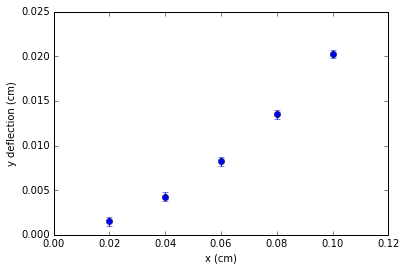

In [84]:
plt.errorbar(xpoints[1],ypoints[1],y_uncertainty[1],linestyle = '',marker = 'o');
plt.xlabel('x (cm)');
plt.ylabel('y deflection (cm)');
plt.xlim(0,.12);

## Fitting function to find radii.

The electron is deflected radially by the field.  
The equation of a circle with radius $a$ centered at $(x,y)=(b,c)$ is given by
$$(x-b)^2+(y-c)^2 = a^2$$
Let's rewrite this in terms of $y$,
$$y=-\sqrt{a^2-(x-b)^2}+c$$
We define the function and then want to find the best estimates for $a, b, c$ consistent with our data.

In [59]:
def myfun(x,a,b,c):
    ans = -np.sqrt(a**2-(x-b)**2)+c  # this is y, "the function to be fit"
    return ans

In [60]:
p0 = [.15, 0, .15]

In [94]:
#Initialize arrays to hold a,b,c for all data
a = np.zeros(len(xpoints)) #Radius
ea = np.zeros(len(xpoints)) #uncertainty
b = np.zeros(len(xpoints)) #x shift
eb = np.zeros(len(xpoints))
c = np.zeros(len(xpoints)) #y shift
ec = np.zeros(len(xpoints))

In [90]:
xlots = np.linspace(.5e-2,11e-2)  # need lots of data points for smooth curve
yfit = np.zeros((len(xpoints),xlots.size))

for i in np.arange(0,len(xpoints)): 
    plsq, pcov = curve_fit(myfun, xpoints[i], ypoints[i], p0, y_uncertainty[i])  # curve fit returns p and covariance matrix
    # these give the parameters and the uncertainties
    a[i] = plsq[0]
    ea[i] = np.sqrt(pcov[0,0])
    b[i] = plsq[1]
    eb[i] = np.sqrt(pcov[1,1])
    c[i] = plsq[2]
    ec[i] = np.sqrt(pcov[2,2])
    yfit[i] = myfun(xlots,plsq[0],plsq[1],plsq[2])  # use fit results for a, b, c
    
print('a = %.3f +/- %.3f' % (plsq[0], np.sqrt(pcov[0,0])))
print('b = %.3f +/- %.3f' % (plsq[1], np.sqrt(pcov[1,1])))
print('c = %.3f +/- %.3f' % (plsq[2], np.sqrt(pcov[2,2])))

a = 0.320 +/- 0.022
b = -0.012 +/- 0.005
c = 0.320 +/- 0.021


Now we use the fitted parameters in our function to compare with the data.

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


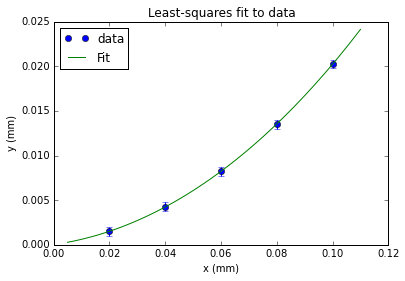

In [93]:
plt.errorbar(xpoints[1],ypoints[1],y_uncertainty[1],linestyle = '',marker = 'o');
plt.xlabel('x (mm)');
plt.ylabel('y (mm)');
plt.plot(xlots,yfit[1]);
plt.title('Least-squares fit to data');
plt.legend(['data','Fit'],loc='best');